In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-v0_8-pastel')

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

import os
from glob import glob  
from PIL import Image
import itertools
np.random.seed(123)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.utils import plot_model    
from tensorflow.keras.callbacks import EarlyStopping

In [1]:

base_skin_dir_1 = '/Users/liteshperumalla/Desktop/Files/Machine Learning Project/archive/HAM10000_images_part_1'
base_skin_dir_2 = '/Users/liteshperumalla/Desktop/Files/Machine Learning Project/archive/HAM10000_images_part_2'

imageid_path_dict = {
    os.path.splitext(os.path.basename(x))[0]: x
    for x in glob(os.path.join(base_skin_dir_1, '*.jpg')) + glob(os.path.join(base_skin_dir_2, '*.jpg'))
}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [2]:

skin_df = pd.read_csv('/Users/liteshperumalla/Desktop/Files/Machine Learning Project/archive/HAM10000_metadata.csv')

skin_df['path'] = skin_df['image_id'].map(imageid_path_dict.get)
skin_df['cell_type'] = skin_df['dx'].map(lesion_type_dict.get) 
skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes

skin_df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2


In [3]:
skin_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [4]:
skin_df['age'] = skin_df['age'].fillna(skin_df['age'].mean())

In [5]:
print(skin_df.dtypes)

lesion_id         object
image_id          object
dx                object
dx_type           object
age              float64
sex               object
localization      object
path              object
cell_type         object
cell_type_idx       int8
dtype: object


Text(0, 0.5, 'Count')

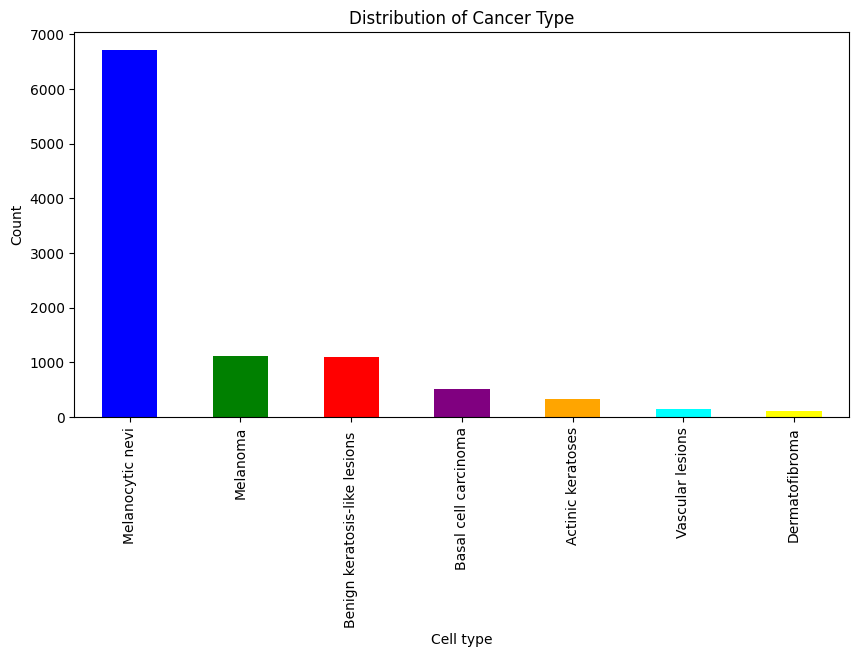

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan', 'yellow']
skin_df['cell_type'].value_counts().plot(kind='bar', ax=ax1, color=colors)
plt.title('Distribution of Cancer Type')
plt.xlabel('Cell type')
plt.ylabel('Count')

Text(0.5, 1.0, 'The type of medical diagnostics performed')

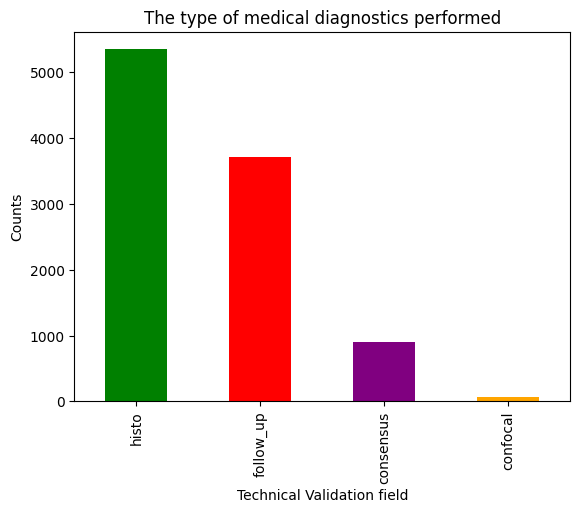

In [7]:
colors = ['green', 'red', 'purple', 'orange', 'cyan', 'yellow']
skin_df['dx_type'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Technical Validation field')
plt.ylabel('Counts')
plt.title('The type of medical diagnostics performed')


Text(0.5, 1.0, 'The body parts most susceptible for skin cancer')

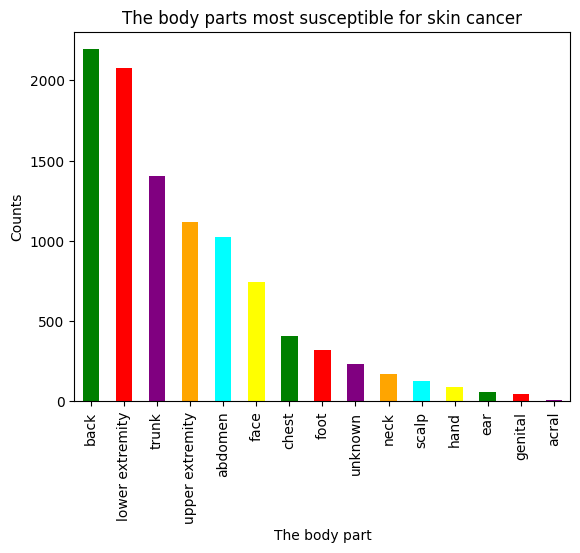

In [8]:
colors = ['green', 'red', 'purple', 'orange', 'cyan', 'yellow']
skin_df['localization'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('The body part')
plt.ylabel('Counts')
plt.title('The body parts most susceptible for skin cancer')

Text(0.5, 1.0, 'Age Distribution')

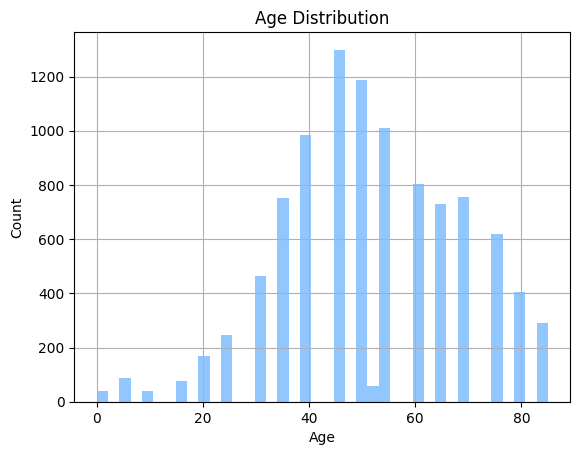

In [9]:
skin_df['age'].hist(bins=40)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution')

In [10]:
skin_df = skin_df.drop(skin_df[skin_df['sex'] == 'unknown'].index)

Text(0.5, 1.0, 'Gender Distribution')

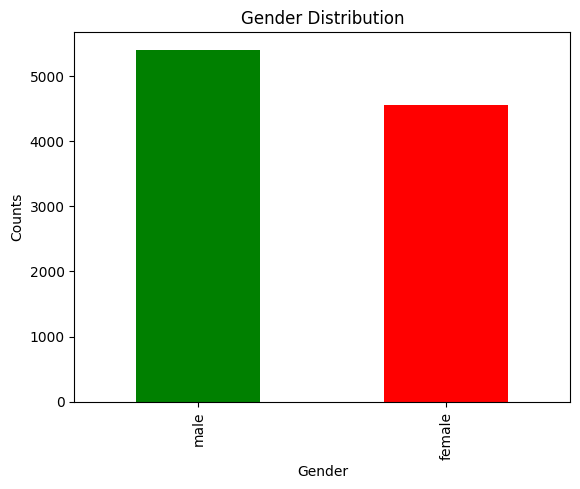

In [11]:
skin_df['sex'].value_counts().plot(kind='bar', color=colors)
plt.xlabel('Gender')
plt.ylabel('Counts')
plt.title('Gender Distribution')

<Axes: xlabel='age', ylabel='cell_type_idx'>

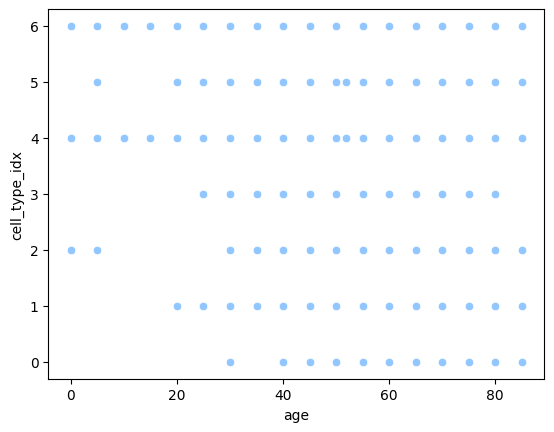

In [12]:
sns.scatterplot(data=skin_df, x= 'age',y='cell_type_idx')

<Axes: xlabel='cell_type_idx', ylabel='Density'>

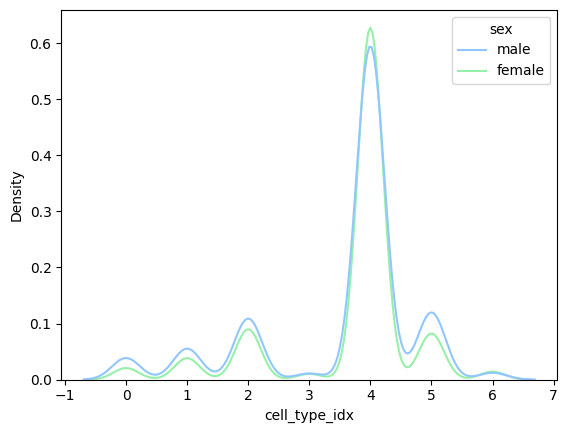

In [13]:
sns.kdeplot(data=skin_df, x='cell_type_idx', hue='sex')

In [14]:

def load_and_resize_image(path):
    image = tf.io.read_file(path)  
    image = tf.image.decode_jpeg(image, channels=3)  
    image = tf.image.resize(image, [75, 100])  
    return image

image_paths = skin_df['path'].values


image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
image_dataset = image_dataset.map(lambda x: load_and_resize_image(x), num_parallel_calls=tf.data.AUTOTUNE)
image_dataset = image_dataset.batch(32)  
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE) 


In [15]:

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [16]:
skin_df['image'] = skin_df['path'].map(lambda x: load_and_resize_image(x))

In [17]:
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(189.75, shape=(), dtype=float32),..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(23.75, shape=(), dtype=float32), ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(185.25, shape=(), dtype=float32),..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(22.5, shape=(), dtype=float32), t..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,2,"(((tf.Tensor(131.75, shape=(), dtype=float32),..."


In [18]:
skin_df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    9958
Name: count, dtype: int64

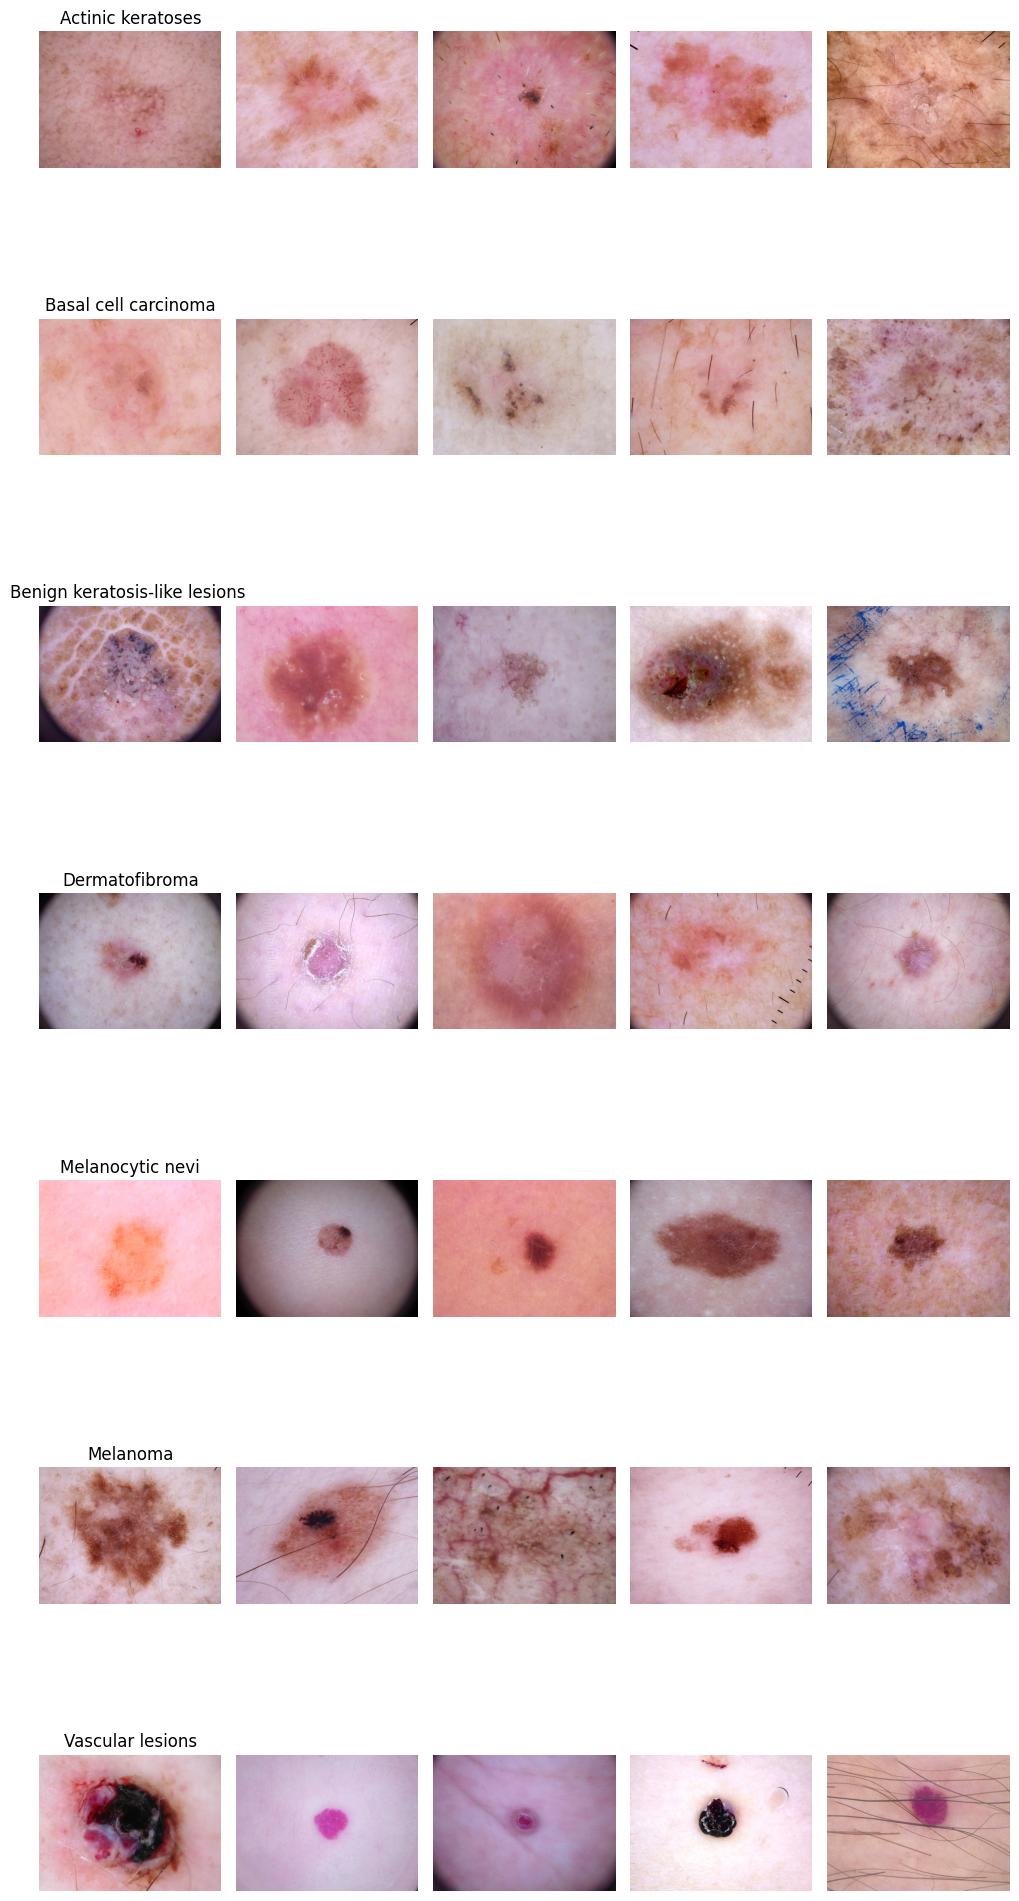

In [20]:
n_samples = 5

fig, m_axs = plt.subplots(7, n_samples, figsize=(2 * n_samples, 3 * 7))

for n_axs, (type_name, type_rows) in zip(m_axs, skin_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)  
    
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=42).iterrows()):
       
        image = Image.open(c_row['path'])
        image_array = np.array(image)
        
       
        c_ax.imshow(image_array.astype('uint8'))
        c_ax.axis('off')  

fig.savefig('category_samples.png', dpi=300)
plt.tight_layout()
plt.show()

In [21]:
features = skin_df.drop(columns=['cell_type_idx'],axis=1)
target = skin_df['cell_type_idx']

In [22]:
features.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,image
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(189.75, shape=(), dtype=float32),..."
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(23.75, shape=(), dtype=float32), ..."
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(185.25, shape=(), dtype=float32),..."
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(22.5, shape=(), dtype=float32), t..."
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/Users/liteshperumalla/Desktop/Files/Machine L...,Benign keratosis-like lesions,"(((tf.Tensor(131.75, shape=(), dtype=float32),..."


In [23]:
target.value_counts()

cell_type_idx
4    6658
5    1113
2    1089
1     514
0     327
6     142
3     115
Name: count, dtype: int64

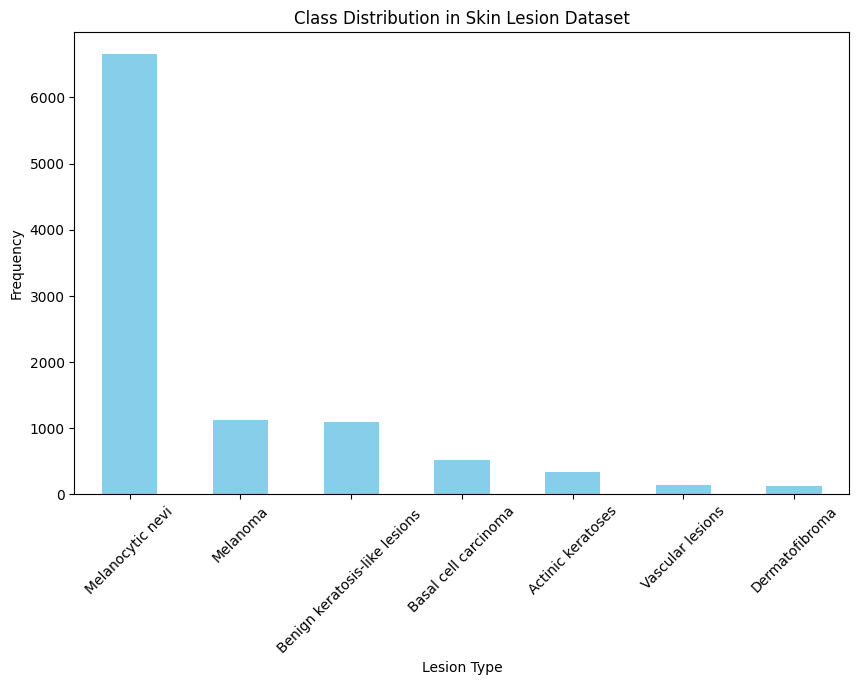

cell_type
Melanocytic nevi                  6658
Melanoma                          1113
Benign keratosis-like lesions     1089
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: count, dtype: int64

In [24]:
import matplotlib.pyplot as plt

class_counts = skin_df['cell_type'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution in Skin Lesion Dataset')
plt.xlabel('Lesion Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

class_counts

In [25]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=42)

In [26]:
x_train_o.shape

(7966, 10)

In [27]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_test_mean = np.mean(x_test)

x_train_std = np.std(x_train)
x_test_std = np.std(x_test)

X_train = (x_train - x_train_mean) / x_train_std
X_test = (x_test - x_test_mean) / x_test_std

In [28]:
X_train.shape

(7966, 75, 100, 3)

In [29]:
# Assuming y_train_o is your integer encoded labels
y_train = to_categorical(y_train_o, num_classes=7)
y_test = to_categorical(y_test_o, num_classes=7)

In [30]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [31]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
X_train.shape

(7169, 75, 100, 3)

In [32]:
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

if len(y_train.shape) > 1 and y_train.shape[1] > 1:
    y_train_labels = np.argmax(y_train, axis=1)
else:
    y_train_labels = y_train


initial_counts = Counter(y_train_labels)


smote_strategy = {key: 1000 for key in initial_counts.keys() if initial_counts[key] < 1000}
undersample_strategy = {key: int(0.5 * initial_counts[key]) for key in initial_counts.keys() if initial_counts[key] >= 1000}

over = SMOTE(sampling_strategy=smote_strategy)
under = RandomUnderSampler(sampling_strategy=undersample_strategy)

pipeline = Pipeline(steps=[('o', over), ('u', under)])


X_resampled, y_resampled = pipeline.fit_resample(X_train.reshape(X_train.shape[0], -1), y_train_labels)


print("Class distribution after resampling:", Counter(y_resampled))

X_resampled = X_resampled.reshape(X_resampled.shape[0], *X_train.shape[1:])



Class distribution after resampling: Counter({4: 2391, 0: 1000, 1: 1000, 2: 1000, 3: 1000, 5: 1000, 6: 1000})


In [33]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# Define the number of classes
n_classes = 7

# Load the base model (VGG16) without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(75, 100, 3))

# Freeze the base model layers to prevent them from being trained initially
base_model.trainable = False

# Create a new model and add the base model as the first layer
model = Sequential([
    base_model,  # Add the pretrained base model
    GlobalAveragePooling2D(),  # Global average pooling instead of flattening
    Dense(128, activation='relu'),  # Custom dense layer
    Dropout(0.5),  # Dropout for regularization
    Dense(n_classes, activation='softmax')  # Output layer
])


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8, 1.2]
)

# Create the train_generator
train_generator = datagen.flow(
    X_train, y_train, batch_size=32  # Adjust batch_size as needed
)


In [35]:
from tensorflow.keras.optimizers.legacy import Adam

# Define the optimizer
optimizer = Adam(learning_rate=0.0005)

# Compile the model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model (example with early stopping and learning rate reduction)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

history = model.fit(
    train_generator,  # Use data augmentation if defined
    epochs=25,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/25
225/225 [==============================] - 286s 1s/step - loss: 1.1429 - accuracy: 0.6453 - val_loss: 0.8897 - val_accuracy: 0.6913 - lr: 5.0000e-04
Epoch 2/25
225/225 [==============================] - 287s 1s/step - loss: 0.9351 - accuracy: 0.6855 - val_loss: 0.8197 - val_accuracy: 0.6964 - lr: 5.0000e-04
Epoch 3/25
225/225 [==============================] - 346s 2s/step - loss: 0.8782 - accuracy: 0.6931 - val_loss: 0.7834 - val_accuracy: 0.7189 - lr: 5.0000e-04
Epoch 4/25
225/225 [==============================] - 330s 1s/step - loss: 0.8497 - accuracy: 0.6958 - val_loss: 0.7656 - val_accuracy: 0.7277 - lr: 5.0000e-04
Epoch 5/25
225/225 [==============================] - 301s 1s/step - loss: 0.8244 - accuracy: 0.7080 - val_loss: 0.7497 - val_accuracy: 0.7290 - lr: 5.0000e-04
Epoch 6/25
225/225 [==============================] - 328s 1s/step - loss: 0.8105 - accuracy: 0.7140 - val_loss: 0.7447 - val_accuracy: 0.7277 - lr: 5.0000e-04
Epoch 7/25
225/225 [====================

In [36]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-2:]:  # Adjust number of layers to unfreeze
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

# Train again with fine-tuning
history_fine_tune = model.fit(
    train_generator,
    epochs=5,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/5
225/225 [==============================] - 293s 1s/step - loss: 0.7001 - accuracy: 0.7447 - val_loss: 0.6748 - val_accuracy: 0.7754 - lr: 1.0000e-05
Epoch 2/5
225/225 [==============================] - 291s 1s/step - loss: 0.7026 - accuracy: 0.7463 - val_loss: 0.6746 - val_accuracy: 0.7729 - lr: 1.0000e-05
Epoch 3/5
225/225 [==============================] - 290s 1s/step - loss: 0.7055 - accuracy: 0.7438 - val_loss: 0.6745 - val_accuracy: 0.7716 - lr: 1.0000e-05
Epoch 4/5
225/225 [==============================] - 295s 1s/step - loss: 0.7012 - accuracy: 0.7482 - val_loss: 0.6741 - val_accuracy: 0.7704 - lr: 1.0000e-05
Epoch 5/5
225/225 [==============================] - 297s 1s/step - loss: 0.7007 - accuracy: 0.7493 - val_loss: 0.6740 - val_accuracy: 0.7704 - lr: 1.0000e-05


In [37]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

def improved_cnn_model(input_shape=(75, 100, 3), n_classes=7):
    model1 = Sequential()
    model1.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model1.add(MaxPool2D((2, 2)))
    model1.add(Dropout(0.3))  # Dropout layer to reduce overfitting

    model1.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model1.add(MaxPool2D((2, 2)))
    model1.add(Dropout(0.4))

    model1.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model1.add(MaxPool2D((2, 2)))
    model1.add(Dropout(0.5))

    model1.add(Flatten())
    model1.add(Dense(128, activation='relu'))
    model1.add(Dropout(0.5))
    model1.add(Dense(n_classes, activation='softmax'))
    
    return model


In [38]:
model1 = improved_cnn_model(input_shape=(75, 100, 3), n_classes=7)
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 3, 512)         14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 14781255 (56.39 MB)
Trainable params: 66567 (260.03 KB)
Non-trainable params: 14714688 (56.13 MB)
__________

In [39]:
from tensorflow.keras.optimizers.legacy import Adam

initial_learning_rate = 0.0005
optimizer = Adam(learning_rate=initial_learning_rate)  # Define the optimizer with the learning rate
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [40]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Batch size and epochs
batch_size = 32
epochs = 10

# Resizing images during augmentation to save memory
datagen = ImageDataGenerator(
    rotation_range=30,           # Increase rotation to 30 degrees
    width_shift_range=0.25,      # Increase horizontal shift
    height_shift_range=0.25,     # Increase vertical shift
    shear_range=0.3,             # More shearing for diversity
    zoom_range=[0.8, 1.3],       # Increase zoom range
    horizontal_flip=True,        # Keep random horizontal flips
    brightness_range=[0.7, 1.3], # Expanded brightness range
    fill_mode='nearest'
)

datagen.fit(X_train)

# Training and validation generators with resizing on-the-fly
train_generator = datagen.flow(
    tf.image.resize(X_train, (75, 100)), y_train, batch_size=batch_size
)

# Callbacks to save the best model and stop early if needed
early_stopping = EarlyStopping(
    monitor='val_loss',    # Monitor validation loss
    patience=15,           # Stop if no improvement after 10 epochs
    restore_best_weights=True  # Restore the best model after stopping
)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

model_checkpoint = ModelCheckpoint(
    'best_model.h5',       # Filepath to save the best model
    monitor='val_loss',    # Monitor validation loss
    save_best_only=True    #  Save only the best model
)


# Model training with early stopping and checkpointing
history = model1.fit(
    train_generator,                                 # Augmented and resized training data
    epochs=epochs,                                   # Number of epochs
    validation_data=(tf.image.resize(X_val, (75, 100)), y_val),  # Resized validation data
    steps_per_epoch=len(X_train) // batch_size,      # Steps per epoch
    callbacks=[early_stopping, model_checkpoint, reduce_lr],    # Early stopping and checkpoint callbacks
    verbose=1                                        # Show progress during training
)

Epoch 1/10
224/224 [==============================] - 292s 1s/step - loss: 0.7436 - accuracy: 0.7296 - val_loss: 0.6938 - val_accuracy: 0.7453 - lr: 5.0000e-04
Epoch 2/10


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


224/224 [==============================] - 292s 1s/step - loss: 0.7376 - accuracy: 0.7280 - val_loss: 0.6801 - val_accuracy: 0.7641 - lr: 5.0000e-04
Epoch 3/10
224/224 [==============================] - 293s 1s/step - loss: 0.7333 - accuracy: 0.7328 - val_loss: 0.6821 - val_accuracy: 0.7604 - lr: 5.0000e-04
Epoch 4/10
224/224 [==============================] - 295s 1s/step - loss: 0.7372 - accuracy: 0.7332 - val_loss: 0.6779 - val_accuracy: 0.7591 - lr: 5.0000e-04
Epoch 5/10
224/224 [==============================] - 292s 1s/step - loss: 0.7312 - accuracy: 0.7334 - val_loss: 0.6811 - val_accuracy: 0.7491 - lr: 5.0000e-04
Epoch 6/10
224/224 [==============================] - 292s 1s/step - loss: 0.7316 - accuracy: 0.7370 - val_loss: 0.6723 - val_accuracy: 0.7666 - lr: 5.0000e-04
Epoch 7/10
224/224 [==============================] - 290s 1s/step - loss: 0.7258 - accuracy: 0.7359 - val_loss: 0.6818 - val_accuracy: 0.7578 - lr: 5.0000e-04
Epoch 8/10
224/224 [==============================]

In [51]:
%pip install pydot
%pip install graphviz

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


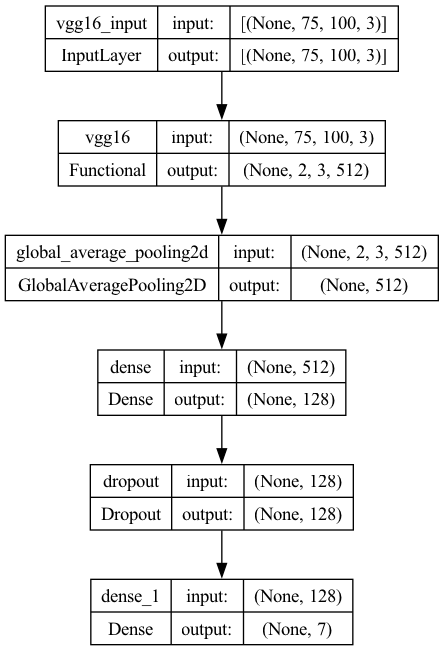

In [41]:
# Test the plot_model functionality
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [42]:
loss, accuracy = model1.evaluate(X_test, y_test, verbose=1)
loss_v, accuracy_v = model1.evaluate(X_val, y_val, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model1.save("model.h5")

25/25 [==============================] - 30s 1s/step - loss: 0.6743 - accuracy: 0.7578
Validation: accuracy = 0.757842  ;  loss_v = 0.674305
Test: accuracy = 0.738956  ;  loss = 0.712252


/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, len(model_history.history['accuracy']) // 10))
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1, len(model_history.history['loss']) // 10))
    axs[1].legend(['train', 'val'], loc='best')
    
    plt.show()

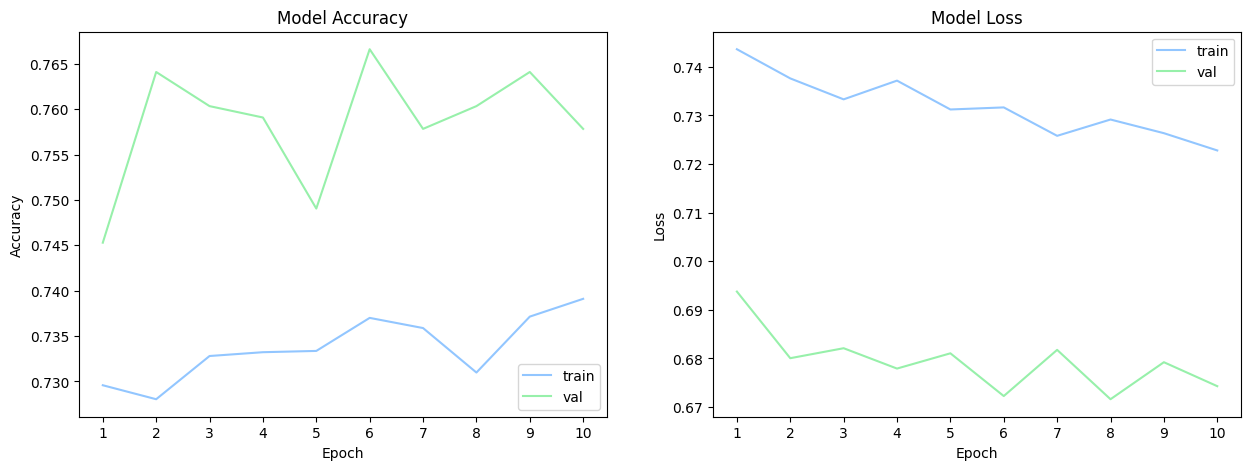

In [44]:
plot_model_history(history)

In [45]:
# Calculate the length of the dataset
ts_length = len(skin_df)

# Set the test batch size based on conditions
test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length % n == 0 and ts_length / n <= 80]))

# Calculate test steps based on the test batch size
test_steps = ts_length // test_batch_size

# Ensure X_train, X_val, and X_test along with y_train, y_val, y_test are properly defined
train_score = model1.evaluate(X_train, y_train, batch_size=test_batch_size, verbose=1)
valid_score = model1.evaluate(X_val, y_val, batch_size=test_batch_size, verbose=1)
test_score = model1.evaluate(X_test, y_test, batch_size=test_batch_size, verbose=1)

# Print scores
print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])


77/77 [==============================] - 72s 943ms/step - loss: 0.7123 - accuracy: 0.7390
Train Loss:  0.6419138312339783
Train Accuracy:  0.7631468772888184
--------------------
Validation Loss:  0.6743045449256897
Validation Accuracy:  0.7578418850898743
--------------------
Test Loss:  0.7122517824172974
Test Accuracy:  0.7389557957649231


In [46]:
# Function to plot confusion matrix    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

25/25 [==============================] - 29s 1s/step


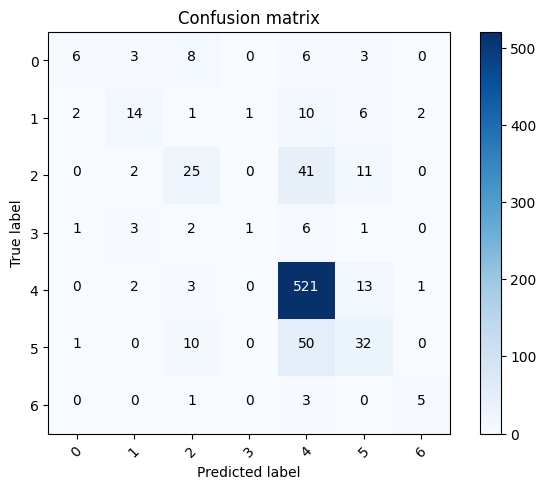

In [47]:
# Predict the values from the validation dataset
y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7)) 

Text(0, 0.5, 'Fraction classified incorrectly')

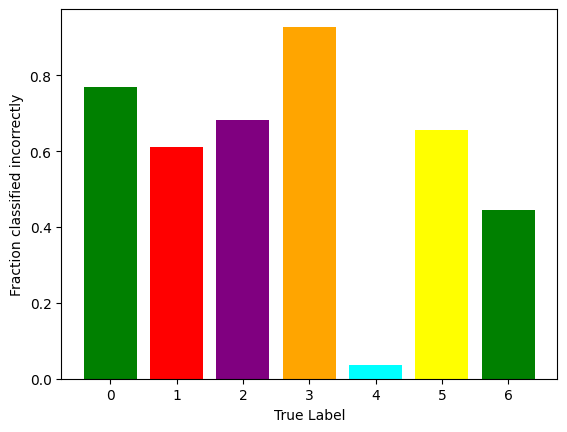

In [48]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(7),label_frac_error, color=colors)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [49]:
import numpy as np

# Assume you have trained multiple models (e.g., model1, model2, model3)
# Predict on the test data for each model
y_pred1 = model.predict(X_test)
y_pred2 = model1.predict(X_test)

# Average the predictions
y_pred_ensemble = (y_pred1 + y_pred2) / 2
y_pred_ensemble_class = np.argmax(y_pred_ensemble, axis=1)  # Convert to class labels if needed


63/63 [==============================] - 73s 1s/step


In [50]:
# Assign weights to each model
w1, w2 = 0.5, 0.3  # Adjust weights based on model performance

# Weighted average of predictions
y_pred_ensemble = (w1 * y_pred1 + w2 * y_pred2) / (w1 + w2)
y_pred_ensemble_class = np.argmax(y_pred_ensemble, axis=1)


In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# Generate predictions from base models for stacking
y_pred1_train = model.predict(X_train)
y_pred2_train = model1.predict(X_train)

y_pred1_test = model.predict(X_test)
y_pred2_test = model1.predict(X_test)

# Concatenate predictions to create new training and test sets for the meta-learner
stacked_train = np.concatenate([y_pred1_train, y_pred2_train], axis=1)
stacked_test = np.concatenate([y_pred1_test, y_pred2_test], axis=1)

# Convert y_train and y_test to class labels if they're one-hot encoded
y_train_labels = np.argmax(y_train, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Meta-learner (e.g., Logistic Regression)
meta_model = LogisticRegression()  
meta_model.fit(stacked_train, y_train_labels)

# Predict on the test set with the meta-model
y_pred_meta = meta_model.predict(stacked_test)
accuracy = accuracy_score(y_test_labels, y_pred_meta)
print("Stacking Ensemble Accuracy:", accuracy)


63/63 [==============================] - 72s 1s/step
Stacking Ensemble Accuracy: 0.7444779116465864
